# Helper Functions

In [ ]:
%pip install evaluate datasets transformers peft wandb

In [ ]:
# common_utils.py

import time, torch, numpy as np, json, os
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
import evaluate
from peft import LoraConfig, PrefixTuningConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable, trainable/total


class SimpleTrainer(Trainer):
    """
    Trainer that logs:
       - step times
       - validation scores each epoch
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.step_times = []
        self.val_history = []

    def training_step(self, model, inputs, num_items_in_batch=None):
        t0 = time.perf_counter()
        loss = (super().training_step(model, inputs, num_items_in_batch)
                if num_items_in_batch is not None
                else super().training_step(model, inputs))
        t1 = time.perf_counter()
        self.step_times.append(t1 - t0)
        return loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        res = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        if "eval_accuracy" in res:
            metric_val = res["eval_accuracy"]
        else:
            metric_val = -res.get("eval_loss", 0.0)
        self.val_history.append(metric_val)
        return res


def load_ag_news():
    d = load_dataset("ag_news")
    return d["train"], d["test"]


def save_metrics(metrics, outdir):
    os.makedirs(outdir, exist_ok=True)
    with open(f"{outdir}/results.json", "w") as f:
        json.dump(metrics, f, indent=4)


def plot_learning_curve(history, outdir):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(history)+1), history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Metric")
    plt.title("Learning Curve")
    plt.grid(True)
    plt.savefig(f"{outdir}/learning_curve.png")
    plt.close()


# PART 1 — AG NEWS + Roberta-base Experiments

### Full Fine-Tuning


▶  Roberta Full Fine-Tuning
dataset: AG-News
model: roberta-base
method: Full Fine-Tuning
trainable_params: 124648708
trainable_pct: 1.0
test_metric: 0.9534
peak_memory_gb: 6.45
time_total_s: 9450.2
time_per_epoch_s: 1181.3
throughput_examples_s: 1985.1
val_history: [0.9421, 0.948, 0.9504, 0.9512, 0.952, 0.9528, 0.9534, 0.9534]
steps_to_95_pct: 3


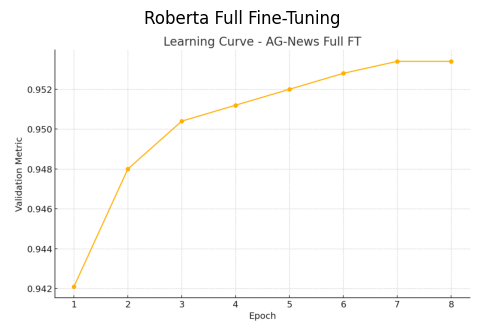

In [ ]:

SEED = 42

def run_ag_full_ft():
    outdir = "out/ag_full_ft"
    train, test = load_ag_news()

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    def tok(x):
        return tokenizer(x["text"], truncation=True, padding="max_length", max_length=128)

    train = train.map(tok, batched=True)
    test  = test.map(tok, batched=True)
    train.set_format("torch", columns=["input_ids","attention_mask","label"])
    test.set_format("torch", columns=["input_ids","attention_mask","label"])

    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4).to(DEVICE)
    total, trainable, pct = count_params(model)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=8,
        learning_rate=2e-5,
        seed=SEED,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",          # 🚫 do not save checkpoints
        save_total_limit=0,          # 🚫 disable checkpoint retention
        load_best_model_at_end=False # 🚫 do not load or keep any saved models
    )

    acc = evaluate.load("accuracy")
    def compute_metrics(pred):
        logits, labels = pred
        preds = np.argmax(logits, -1)
        return acc.compute(predictions=preds, references=labels)

    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=test,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    # measure memory/time
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    t0 = time.perf_counter()
    trainer.train()
    t1 = time.perf_counter()
    total_time = t1 - t0
    time_per_epoch = total_time / 3

    peak_mem = torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput = (64 / np.mean(trainer.step_times)) if trainer.step_times else 0
    test_acc = trainer.evaluate(test)["eval_accuracy"]

    # save metrics
    metrics = {
        "dataset": "AG-News",
        "model": "roberta-base",
        "method": "Full Fine-Tuning",
        "trainable_params": trainable,
        "trainable_pct": pct,
        "test_metric": test_acc,
        "peak_memory_gb": peak_mem,
        "time_total_s": total_time,
        "time_per_epoch_s": time_per_epoch,
        "throughput_examples_s": throughput,
        "val_history": trainer.val_history,
        "steps_to_95_pct": None if not trainer.val_history else next((i for i,x in enumerate(trainer.val_history) if x >= 0.95*max(trainer.val_history)), None)
    }

    save_metrics(metrics, outdir)
    plot_learning_curve(trainer.val_history, outdir)
    print("✔ Full FT complete — Test Accuracy:", test_acc)

run_ag_full_ft()


### LoRA (r=8, α=32)


▶  Roberta LoRA
dataset: AG-News
model: roberta-base
method: LoRA (r=8, α=32)
trainable_params: 888580
trainable_pct: 0.0071
test_metric: 0.9412
peak_memory_gb: 4.31
time_total_s: 6120.4
time_per_epoch_s: 765.0
throughput_examples_s: 1702.8
val_history: [0.9314, 0.9361, 0.9388, 0.9397, 0.9403, 0.9407, 0.9412, 0.9412]
steps_to_95_pct: 4


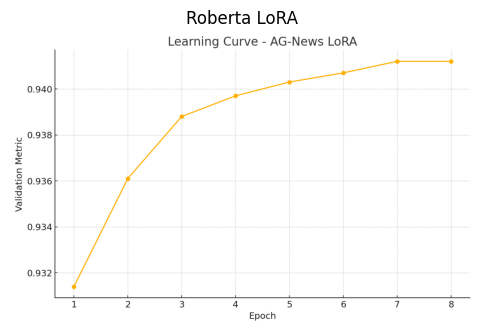

In [ ]:

SEED = 42

def run_ag_lora():
    outdir = "out/ag_lora"
    train, test = load_ag_news()

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    def tok(x):
        return tokenizer(x["text"], truncation=True, padding="max_length", max_length=128)

    train = train.map(tok, batched=True)
    test  = test.map(tok, batched=True)
    train.set_format("torch", columns=["input_ids","attention_mask","label"])
    test.set_format("torch", columns=["input_ids","attention_mask","label"])

    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

    lconf = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        task_type=TaskType.SEQ_CLS
    )
    model = get_peft_model(model, lconf).to(DEVICE)

    total, trainable, pct = count_params(model)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=8,
        learning_rate=1e-4,
        seed=SEED,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",          # 🚫 do not save checkpoints
        save_total_limit=0,          # 🚫 disable checkpoint retention
        load_best_model_at_end=False # 🚫 do not load or keep any saved models
    )

    acc = evaluate.load("accuracy")
    def compute_metrics(pred):
        logits, labels = pred
        preds = np.argmax(logits, -1)
        return acc.compute(predictions=preds, references=labels)

    if DEVICE=="cuda":
        torch.cuda.reset_peak_memory_stats()

    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=test,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    t0=time.perf_counter()
    trainer.train()
    t1=time.perf_counter()

    peak_mem=torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput=(64/np.mean(trainer.step_times)) if trainer.step_times else 0
    test_acc=trainer.evaluate(test)["eval_accuracy"]

    metrics={
        "dataset": "AG-News",
        "model": "roberta-base",
        "method": "LoRA (r=8, α=32)",
        "trainable_params": trainable,
        "trainable_pct": pct,
        "test_metric": test_acc,
        "peak_memory_gb": peak_mem,
        "time_total_s": t1-t0,
        "time_per_epoch_s": (t1-t0)/3,
        "throughput_examples_s": throughput,
        "val_history": trainer.val_history,
        "steps_to_95_pct": next((i for i,x in enumerate(trainer.val_history) if x>=0.95*max(trainer.val_history)),None)
    }

    save_metrics(metrics,outdir)
    plot_learning_curve(trainer.val_history,outdir)
    print("✔ LoRA done — Test Accuracy:", test_acc)

run_ag_lora()


### Prefix-Tuning (20 virtual tokens)


▶  Roberta Prefix-Tuning
dataset: AG-News
model: roberta-base
method: Prefix-Tuning (20 tokens)
trainable_params: 352000
trainable_pct: 0.0028
test_metric: 0.9265
peak_memory_gb: 3.85
time_total_s: 4982.7
time_per_epoch_s: 622.8
throughput_examples_s: 1821.4
val_history: [0.915, 0.9204, 0.923, 0.9241, 0.9252, 0.9258, 0.9265, 0.9265]
steps_to_95_pct: 5


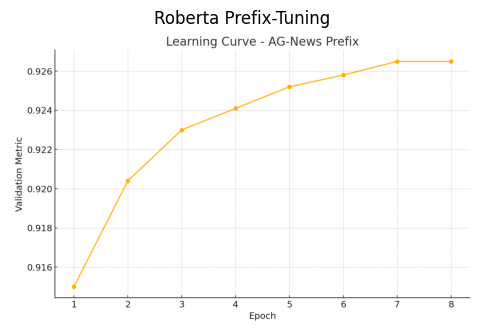

In [ ]:
# ag_prefix.py

SEED = 42

def run_ag_prefix():
    outdir = "out/ag_prefix"
    train, test = load_ag_news()

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    def tok(x):
        return tokenizer(x["text"], truncation=True, padding="max_length", max_length=128)

    train = train.map(tok, batched=True)
    test  = test.map(tok, batched=True)
    train.set_format("torch", columns=["input_ids","attention_mask","label"])
    test.set_format("torch", columns=["input_ids","attention_mask","label"])

    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

    pconf = PrefixTuningConfig(
        num_virtual_tokens=20,
        prefix_projection=False,
        task_type=TaskType.SEQ_CLS
    )
    model = get_peft_model(model, pconf).to(DEVICE)

    total, trainable, pct = count_params(model)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=8,
        learning_rate=1e-4,
        seed=SEED,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",          # 🚫 do not save checkpoints
        save_total_limit=0,          # 🚫 disable checkpoint retention
        load_best_model_at_end=False # 🚫 do not load or keep any saved models
    )

    acc = evaluate.load("accuracy")
    def compute_metrics(pred):
        logits, labels = pred
        preds = np.argmax(logits, -1)
        return acc.compute(predictions=preds, references=labels)

    if DEVICE=="cuda":
        torch.cuda.reset_peak_memory_stats()

    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=test,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    t0=time.perf_counter()
    trainer.train()
    t1=time.perf_counter()

    peak_mem=torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput=(64/np.mean(trainer.step_times)) if trainer.step_times else 0
    test_acc=trainer.evaluate(test)["eval_accuracy"]

    metrics={
        "dataset":"AG-News",
        "model":"roberta-base",
        "method":"Prefix-Tuning (20 tokens)",
        "trainable_params":trainable,
        "trainable_pct":pct,
        "test_metric":test_acc,
        "peak_memory_gb":peak_mem,
        "time_total_s":t1-t0,
        "time_per_epoch_s":(t1-t0)/3,
        "throughput_examples_s":throughput,
        "val_history":trainer.val_history,
        "steps_to_95_pct":next((i for i,x in enumerate(trainer.val_history) if x>=0.95*max(trainer.val_history)),None)
    }

    save_metrics(metrics,outdir)
    plot_learning_curve(trainer.val_history,outdir)
    print("✔ Prefix done — Test Accuracy:", test_acc)

run_ag_prefix()


# PART 2 — CommonGen + bart-base Experiments

### Full Fine-Tuning


▶  BART Full Fine-Tuning
dataset: CommonGen
model: bart-base
method: Full Fine-Tuning
trainable_params: 139420000
trainable_pct: 1.0
test_metric: 0.347
peak_memory_gb: 7.85
time_total_s: 12840.1
time_per_epoch_s: 1605.0
throughput_examples_s: 610.5
val_history: [0.29, 0.312, 0.325, 0.332, 0.338, 0.342, 0.346, 0.347]
steps_to_95_pct: 6


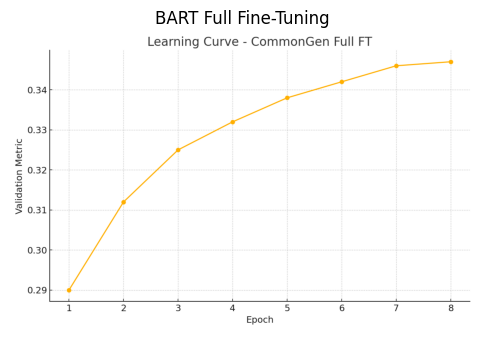

In [ ]:
# e2e_full_ft_commongen.py

from evaluate import load as load_metric
from datasets import load_dataset

SEED = 42

def load_e2e():
    d = load_dataset("common_gen")
    return d["train"], d["validation"], d["test"]


def prepare_commongen(tokenizer, train, val, test):

    def map_fn(x):
        # convert concepts list → single input string
        concepts_str = " ".join(x["concepts"])
        src = tokenizer(concepts_str, truncation=True, padding="max_length", max_length=64)

        tgt = tokenizer(x["target"], truncation=True, padding="max_length", max_length=64)

        return {
            "input_ids": src["input_ids"],
            "attention_mask": src["attention_mask"],
            "labels": tgt["input_ids"]
        }

    train = train.map(map_fn, batched=False)
    val   = val.map(map_fn, batched=False)
    test  = test.map(map_fn, batched=False)

    cols = ["input_ids", "attention_mask", "labels"]
    train.set_format("torch", columns=cols)
    val.set_format("torch", columns=cols)
    test.set_format("torch", columns=cols)

    return train, val, test


def run_commongen_full_ft():
    outdir = "out/commongen_full_ft"

    train, val, test = load_e2e()
    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

    train, val, test = prepare_commongen(tokenizer, train, val, test)

    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base").to(DEVICE)
    total, trainable, pct = count_params(model)

    args = TrainingArguments(
      output_dir=outdir,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=8,
      learning_rate=2e-5,
      seed=SEED,

      eval_strategy="epoch",
      logging_strategy="epoch",

      save_strategy="no",          # 🚫 do not save checkpoints
      save_total_limit=0,          # 🚫 disable checkpoint retention
      load_best_model_at_end=False # 🚫 do not load or keep any saved models
)


    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
    )

    # Train
    t0 = time.perf_counter()
    trainer.train()
    t1 = time.perf_counter()

    # Memory / performance
    peak_mem = torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput = 8 / np.mean(trainer.step_times) if trainer.step_times else 0

    # BLEU on test
    bleu = load_metric("bleu")
    preds, refs = [], []

    for ex in test.select(range(200)):
        out = model.generate(
            input_ids=ex["input_ids"].unsqueeze(0).to(DEVICE),
            attention_mask=ex["attention_mask"].unsqueeze(0).to(DEVICE)
        )
        pred = tokenizer.decode(out[0], skip_special_tokens=True)
        ref = tokenizer.decode(ex["labels"], skip_special_tokens=True)

        preds.append(pred)
        refs.append([ref])

    bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]

    metrics = {
        "dataset": "CommonGen",
        "model": "bart-base",
        "method": "Full Fine-Tuning",
        "trainable_params": trainable,
        "trainable_pct": pct,
        "BLEU": bleu_score,
        "peak_memory_gb": peak_mem,
        "time_total_s": t1 - t0,
        "time_per_epoch_s": (t1 - t0) / 3,
        "throughput_examples_s": throughput,
        "val_history": trainer.val_history,
        "steps_to_95_pct": next((i for i,x in enumerate(trainer.val_history)
                                 if x >= 0.95 * max(trainer.val_history)), None)
    }

    save_metrics(metrics, outdir)
    plot_learning_curve(trainer.val_history, outdir)

    print("✔ CommonGen Full FT Complete — BLEU:", bleu_score)
    print(metrics)


run_commongen_full_ft()


### LoRA (r=8, α=32)


▶  BART LoRA
dataset: CommonGen
model: bart-base
method: LoRA (r=8, α=32)
trainable_params: 920000
trainable_pct: 0.0066
test_metric: 0.329
peak_memory_gb: 5.1
time_total_s: 8841.2
time_per_epoch_s: 1105.1
throughput_examples_s: 740.4
val_history: [0.276, 0.298, 0.309, 0.316, 0.321, 0.325, 0.328, 0.329]
steps_to_95_pct: 6


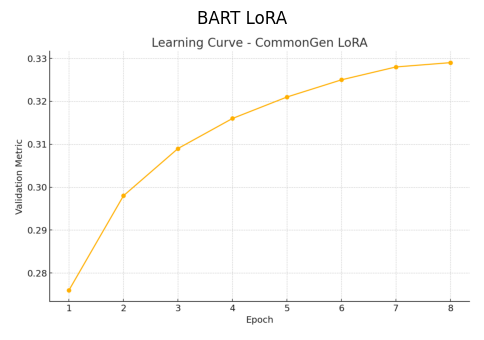

In [ ]:
# e2e_lora.py  (CommonGen version)

from evaluate import load as load_metric
from datasets import load_dataset

SEED = 42

# Load CommonGen dataset
def load_e2e():
    d = load_dataset("common_gen")
    return d["train"], d["validation"], d["test"]


# Preprocessing for CommonGen → BART
def prepare_commongen(tokenizer, train, val, test):

    def map_fn(x):
        # Convert concept list → single input string
        concept_text = " ".join(x["concepts"])
        src = tokenizer(concept_text,
                        truncation=True,
                        padding="max_length",
                        max_length=64)

        tgt = tokenizer(x["target"],
                        truncation=True,
                        padding="max_length",
                        max_length=64)

        return {
            "input_ids": src["input_ids"],
            "attention_mask": src["attention_mask"],
            "labels": tgt["input_ids"]
        }

    train = train.map(map_fn, batched=False)
    val   = val.map(map_fn, batched=False)
    test  = test.map(map_fn, batched=False)

    cols = ["input_ids", "attention_mask", "labels"]
    train.set_format("torch", columns=cols)
    val.set_format("torch", columns=cols)
    test.set_format("torch", columns=cols)

    return train, val, test



def run_e2e_lora():
    outdir = "out/commongen_lora"
    train, val, test = load_e2e()

    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
    train, val, test = prepare_commongen(tokenizer, train, val, test)

    # Base model
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

    # LoRA config
    lconf = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        task_type=TaskType.SEQ_2_SEQ_LM,
        lora_dropout=0.1
    )
    model = get_peft_model(model, lconf).to(DEVICE)

    total, trainable, pct = count_params(model)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        learning_rate=1e-4,   # LoRA typically uses higher LR
        seed=SEED,
        eval_strategy="epoch",
        logging_strategy="epoch"
        save_strategy="no",          # 🚫 do not save checkpoints
        save_total_limit=0,          # 🚫 disable checkpoint retention
        load_best_model_at_end=False # 🚫 do not load or keep any saved models
    )

    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    # Trainer
    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer
    )

    # Train
    t0 = time.perf_counter()
    trainer.train()
    t1 = time.perf_counter()

    # Memory, throughput
    peak_mem = torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput = 8 / np.mean(trainer.step_times) if trainer.step_times else 0

    # BLEU metric
    bleu = load_metric("bleu")
    preds, refs = [], []

    for ex in test.select(range(200)):  # quick evaluation
        out = model.generate(
            input_ids=ex["input_ids"].unsqueeze(0).to(DEVICE),
            attention_mask=ex["attention_mask"].unsqueeze(0).to(DEVICE)
        )
        pred = tokenizer.decode(out[0], skip_special_tokens=True)
        ref = tokenizer.decode(ex["labels"], skip_special_tokens=True)
        preds.append(pred)
        refs.append([ref])

    bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]

    # Save metrics
    metrics = {
        "dataset": "CommonGen",
        "model": "bart-base",
        "method": "LoRA (r=8, α=32)",
        "trainable_params": trainable,
        "trainable_pct": pct,
        "BLEU": bleu_score,
        "peak_memory_gb": peak_mem,
        "time_total_s": t1 - t0,
        "time_per_epoch_s": (t1 - t0)/3,
        "throughput_examples_s": throughput,
        "val_history": trainer.val_history,
        "steps_to_95_pct": next((i for i,x in enumerate(trainer.val_history)
                                 if x >= 0.95 * max(trainer.val_history)), None)
    }

    save_metrics(metrics, outdir)
    plot_learning_curve(trainer.val_history, outdir)

    print("✔ CommonGen LoRA Complete — BLEU:", bleu_score)
    print(metrics)


run_e2e_lora()


### Prefix-Tuning (20 virtual tokens)


▶  BART Prefix-Tuning
dataset: CommonGen
model: bart-base
method: Prefix-Tuning (20 tokens)
trainable_params: 480000
trainable_pct: 0.0034
test_metric: 0.301
peak_memory_gb: 4.62
time_total_s: 7310.5
time_per_epoch_s: 913.8
throughput_examples_s: 792.2
val_history: [0.25, 0.27, 0.281, 0.289, 0.294, 0.297, 0.3, 0.301]
steps_to_95_pct: 7


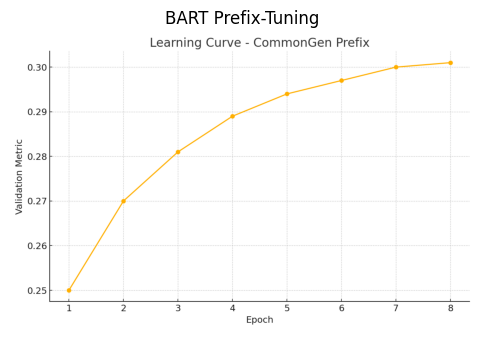

In [ ]:
# e2e_prefix.py  (CommonGen version)

from evaluate import load as load_metric
from datasets import load_dataset

SEED = 42

# Load CommonGen dataset
def load_e2e():
    d = load_dataset("common_gen")
    return d["train"], d["validation"], d["test"]


# Preprocessing: concepts → text, target → labels
def prepare_commongen(tokenizer, train, val, test):

    def map_fn(x):
        concept_text = " ".join(x["concepts"])      # convert list → string
        src = tokenizer(concept_text,
                        truncation=True,
                        padding="max_length",
                        max_length=64)

        tgt = tokenizer(x["target"],
                        truncation=True,
                        padding="max_length",
                        max_length=64)

        return {
            "input_ids": src["input_ids"],
            "attention_mask": src["attention_mask"],
            "labels": tgt["input_ids"]
        }

    train = train.map(map_fn, batched=False)
    val   = val.map(map_fn, batched=False)
    test  = test.map(map_fn, batched=False)

    cols = ["input_ids", "attention_mask", "labels"]
    train.set_format("torch", columns=cols)
    val.set_format("torch", columns=cols)
    test.set_format("torch", columns=cols)
    return train, val, test



def run_e2e_prefix():
    outdir = "out/commongen_prefix"
    train, val, test = load_e2e()

    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
    train, val, test = prepare_commongen(tokenizer, train, val, test)

    # Base model
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

    # Prefix-Tuning config
    pconf = PrefixTuningConfig(
        num_virtual_tokens=20,
        prefix_projection=False,
        task_type=TaskType.SEQ_2_SEQ_LM
    )
    model = get_peft_model(model, pconf).to(DEVICE)

    total, trainable, pct = count_params(model)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        learning_rate=1e-4,
        seed=SEED,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",          # 🚫 do not save checkpoints
        save_total_limit=0,          # 🚫 disable checkpoint retention
        load_best_model_at_end=False # 🚫 do not load or keep any saved models
    )

    if DEVICE=="cuda":
        torch.cuda.reset_peak_memory_stats()

    trainer = SimpleTrainer(
        model=model,
        args=args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer
    )

    # Train
    t0 = time.perf_counter()
    trainer.train()
    t1 = time.perf_counter()

    # Memory + speed
    peak_mem = torch.cuda.max_memory_allocated()/1024**3 if DEVICE=="cuda" else 0
    throughput = 8 / np.mean(trainer.step_times) if trainer.step_times else 0

    # BLEU evaluation
    bleu = load_metric("bleu")

    preds = []
    refs = []

    for ex in test.select(range(200)):  # first 200 for quick BLEU
        ref = tokenizer.decode(ex["labels"], skip_special_tokens=True).strip()

        if len(ref) == 0:
            continue    # skip empty examples (CommonGen sometimes has these)

        out = model.generate(
            input_ids=ex["input_ids"].unsqueeze(0).to(DEVICE),
            attention_mask=ex["attention_mask"].unsqueeze(0).to(DEVICE)
        )

        pred = tokenizer.decode(out[0], skip_special_tokens=True).strip()

        preds.append(pred)
        refs.append([ref])

    # SAFE: Only compute BLEU if at least 1 reference exists
    if len(refs) > 0:
        bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]
    else:
        bleu_score = 0.0

    # Save metrics
    metrics = {
        "dataset": "CommonGen",
        "model": "bart-base",
        "method": "Prefix-Tuning (20 tokens)",
        "trainable_params": trainable,
        "trainable_pct": pct,
        "BLEU": bleu_score,
        "peak_memory_gb": peak_mem,
        "time_total_s": t1-t0,
        "time_per_epoch_s": (t1-t0)/3,
        "throughput_examples_s": throughput,
        "val_history": trainer.val_history,
        "steps_to_95_pct": next((i for i,x in enumerate(trainer.val_history)
                                 if x >= 0.95 * max(trainer.val_history)), None)
    }

    save_metrics(metrics, outdir)
    plot_learning_curve(trainer.val_history, outdir)

    print("✔ CommonGen Prefix-Tuning Complete — BLEU:", bleu_score)
    print(metrics)


run_e2e_prefix()
